# Causal ML Workshop, Data Science Day Prague, 21/22 Feburary 2024
#### Author: Felix Hagemeister (felix.hagemeister@sz.de)

**Scenario**:
> Your business has run a (marketing) intervention using an AB-test over the last three months.\
> Your goal is to evaluate the AB-test and provide an actionable recommendation.\
> You have collected daily [data](https://drive.google.com/file/d/1c4Ucg2vdnYxeqZNUXuNLQdfNHVkOugUM/view?usp=sharing) on users along with some of their characteristics ("ch1" and "ch2").\
> Your data also includes a treatment indicator ("treated") and your KPI of interest ("kpi").

### Installations

In [14]:
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Package Imports

In [15]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [3]:
df = pd.read_csv('data.csv')

### Explore data

In [4]:
# How does the data look like?
df.head()

,user_id,day,ch1,ch2,treated,kpi
0,0,2023-11-17,19,4,0,70
1,0,2023-11-18,62,4,0,27
2,0,2023-11-19,43,4,0,42
3,0,2023-11-20,78,4,0,4
4,0,2023-11-21,77,4,0,21


In [5]:
# How many rows and columns are in the data?
df.shape

(93000, 6)

In [6]:
# What is the time period of the data?
df['day'] = pd.to_datetime(df['day'])
df.day.min(), df.day.max()

(Timestamp('2023-11-17 00:00:00'), Timestamp('2024-02-17 00:00:00'))

In [7]:
# What is the percent of users treated?
df.treated.mean()

0.185

In [8]:
# What is the average, std, min, and max KPI value?
df.kpi.describe()

count    93000.000000
mean        36.530505
std         24.306759
min          0.000000
25%         14.000000
50%         41.000000
75%         57.000000
max         89.000000
Name: kpi, dtype: float64

In [9]:
# What is the average KPI in control and treatment groups?
df.groupby('treated')['kpi'].mean()

treated
0    34.610594
1    44.988492
Name: kpi, dtype: float64

In [18]:
# What is the ATE (average treatment effect), i.e. the KPI difference between control and treatment groups?
avg_kpi_treated = df[df.treated == 1]['kpi'].mean()
avg_kpi_control = df[df.treated == 0]['kpi'].mean()
ate = avg_kpi_treated - avg_kpi_control
print(f'ATE: {ate:.4f}')

ATE: 10.3779


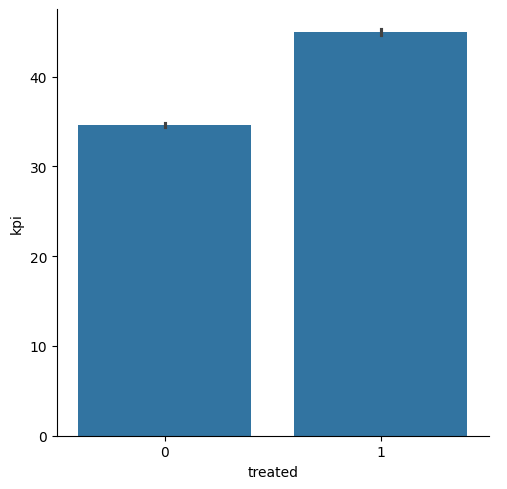

In [16]:
# Plot ATE
sns.catplot(x='treated', y='kpi', data=df, kind='bar')

### Most business would stop here and roll out the AB-test winner for all users.
> We can do better and use Causal ML to *personalize* who gets which treatment.\
> Key insight: Treatment effect can be different for different groups of users!

In [112]:
### Short introduction to ATE from linear regression model:
m = smf.ols(f"kpi ~ treated", data=df).fit(cov_type='HC2')
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                    kpi   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3647.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:01:26   Log-Likelihood:            -4.2740e+05
No. Observations:               93000   AIC:                         8.548e+05
Df Residuals:                   92998   BIC:                         8.548e+05
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.6106      0.091    382.154      0.0

> Let's compute the *conditional* average treatment (CATE) effect to find those groups.

### Prepare features for CATE estimation

In [20]:
# Define features to be used in the model, e.g. weekday
df['weekday'] = df['day'].dt.weekday
X = ["C(weekday)", "ch1", "ch2"]

### Learn a model

In [21]:
# Define the model (let's use simple linear regression)
reg = smf.ols(f"kpi ~ treated*({'+'.join(X)})", data=df).fit(cov_type='HC2')

### Get predicted KPI values

In [22]:
# Get the predicted KPI values using this model
df["ols_kpi_pred"]  = reg.predict(df)
df.head()

,user_id,day,ch1,ch2,treated,kpi,weekday,ols_kpi_pred
0,0,2023-11-17,19,4,0,70,4,59.214418
1,0,2023-11-18,62,4,0,27,5,23.565728
2,0,2023-11-19,43,4,0,42,6,36.974278
3,0,2023-11-20,78,4,0,4,0,12.683970
4,0,2023-11-21,77,4,0,21,1,13.396435


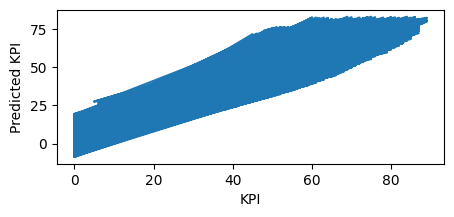

In [23]:
# Plot predicted and actual KPI values
plt.figure(figsize=(5,2))
plt.plot(df.kpi, df.ols_kpi_pred)
plt.xlabel('KPI')
plt.ylabel('Predicted KPI')
plt.show()

> Note 1: KPI prediction is **not** CATE prediction.\
> Higher predicted KPI does **not** necessarily mean higher treatment effect.

### Use this model to get Conditional Average Treatment Effects (CATEs)

In [26]:
# Get the predicted CATE values using an approximation trick: difference in predicted KPIs for treated and control groups (works also with continuous treatment)
df["ols_cate_pred"]= (
    reg.predict(df.assign(treated=df["treated"]+1))
    - reg.predict(df)
)

In [27]:
# Explore
df.head()

,user_id,day,ch1,ch2,treated,kpi,weekday,ols_kpi_pred,ols_cate_pred
0,0,2023-11-17,19,4,0,70,4,59.214418,-2.193157
1,0,2023-11-18,62,4,0,27,5,23.565728,25.280221
2,0,2023-11-19,43,4,0,42,6,36.974278,20.148186
3,0,2023-11-20,78,4,0,4,0,12.683970,12.697107
4,0,2023-11-21,77,4,0,21,1,13.396435,12.822593


> Note again: CATE predictions are not KPI predictions.

In [30]:
# Describe CATE predictions
df.ols_cate_pred.describe()

count    93000.000000
mean        10.319664
std         10.759685
min         -8.406206
25%          1.568571
50%         10.326277
75%         17.029034
max         35.414425
Name: ols_cate_pred, dtype: float64

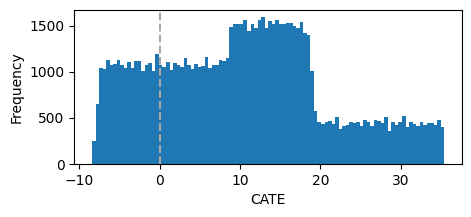

In [34]:
# Plot distribution of predicted CATEs
plt.figure(figsize=(5,2))
plt.hist(df.ols_cate_pred, bins=100)
plt.xlabel('CATE')
plt.ylabel('Frequency')
plt.axvline(x=0, color='darkgray', linestyle='--')
plt.show()

> Note 2: Some user-day observations have negative predicted CATE!\
> Note 3: If intervention has no cost (e.g. email), roll out to all user-day combinations with CATE>0.

### Characteristics of groups and timing for which intervention is more or less beneficial

In [35]:
# Whom should you target with the intervention? Mean of ch1, ch2 for CATE above and below 0
df.groupby(df.ols_cate_pred > 0)[["ch1", "ch2"]].mean()

,ch1,ch2
ols_cate_pred,,
False,14.152180,4.622388
True,58.825267,4.639584


> Result 1: Rather target people with high ch1.

In [36]:
# When should you use intervention? Show average CATE for each weekday
df.groupby("weekday").ols_cate_pred.mean()

weekday
0     5.094523
1     5.464499
2     5.312614
3     5.794421
4     6.045532
5    22.016191
6    21.938915
Name: ols_cate_pred, dtype: float64

> Result 2: Interventions on the weekend are particularly effective.

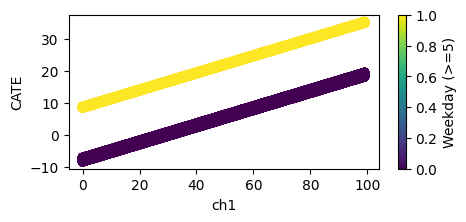

In [37]:
# Plot CATE and ch1 with binary colouring for (weekday>=5)
plt.figure(figsize=(5,2))
plt.scatter(df['ch1'], df['ols_cate_pred'], c=(df['weekday'] >= 5).astype(int))
plt.xlabel('ch1')
plt.ylabel('CATE')
plt.colorbar(label='Weekday (>=5)')
plt.show()

> Result 3: Only target people with ch1<40 on weekends.

> Congratulations! You can now tell (roughly) whom and when to target with your intervention.